# PetFinder: Modeling

In [75]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

import lightgbm as lgb

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error, cohen_kappa_score

## 1. Data cleaning

In [51]:
train_df = pd.read_csv('./data/train/train.csv', dtype={'PhotoAmt': np.int64})
test_df = pd.read_csv('./data/test/test.csv', dtype={'PhotoAmt': np.int64})
pet_ids_to_submit = test_df['PetID'].values

In [52]:
# Correct possible data errors

# Replace Breed1 with Breed2
train_df['Breed1'].replace(0, train_df['Breed2'], inplace=True)

# Replace Breed1 with 0
ids = ['1bc0f89d8', '15a206d0d', 'f8654865f', '36b20cfb5',
       '699a81c51', '85ec1aac0','6a72cfda7'] 
train_df.loc[train_df['PetID'].isin(ids), 'Breed1'] = 0
ids = ['199ae3a3d', '66b38c4a7']
test_df.loc[test_df['PetID'].isin(ids), 'Breed1'] = 0

# Replace Breed2 with 0
ids = ['f8654865f', '699a81c51', '6a72cfda7']
train_df.loc[train_df['PetID'].isin(ids), 'Breed2'] = 0

# Change Type to 1
train_df.loc[train_df['PetID'] == '6c399cb06', 'Type'] = 1

## 2. Feature engineering

In [53]:
# New features

# Add name length
train_df['name_len'] = train_df['Name'].map(len, na_action='ignore')
test_df['name_len'] = test_df['Name'].map(len, na_action='ignore')

# Add total number of pets the rescuer saved
train_df['rescuer_count'] = train_df['RescuerID'].replace(train_df.groupby(['RescuerID']).size())
test_df['rescuer_count'] = test_df['RescuerID'].replace(test_df.groupby(['RescuerID']).size())

# Add description length
train_df['desc_len'] = train_df['Description'].map(len, na_action='ignore')
test_df['desc_len'] = test_df['Description'].map(len, na_action='ignore')

## 3. Modeling

### 3.1 Metrics

In [54]:
# RMSE as objective
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Quadratic weighted kappa. This is the evaluation metric.
def qwk(y_true, y_pred):
    return cohen_kappa_score(y_true, y_pred, weights='quadratic')

### 3.2 Thresholds selection

In [71]:
def get_thresholds_from_dist(y_true, y_pred):
    """Calculates thresholds for raw predictions
    so as to follow the true distribution.
    """
    idxs = np.cumsum(np.bincount(y_train))[:-1]
    idxs = (idxs * y_pred.size / y_true.size).astype(int)
    return np.sort(y_pred)[idxs]

def allocate_to_rate(y_pred, thresholds):
    """Allocates raw predictions to adoption rates."""
    rates = np.zeros(y_pred.size, dtype=int)
    for i in range(4):
        rates[y_pred >= thresholds[i]] = i + 1
    return rates

### 3.3 Training

In [56]:
# Drop these for now
train_df.drop(columns=['Name', 'RescuerID', 'Description', 'PetID'], inplace=True)
test_df.drop(columns=['Name', 'RescuerID', 'Description', 'PetID'], inplace=True)

In [57]:
# Define categorical and numerical features
cat_feats = ['Type', 'Breed1', 'Breed2', 'Gender',
             'Color1', 'Color2', 'Color3', 'Vaccinated',
             'Dewormed', 'Sterilized', 'State']
num_feats = ['MaturitySize', 'FurLength', 'Health', 'Quantity',
             'Fee', 'VideoAmt', 'PhotoAmt', 'name_len',
             'rescuer_count']

In [58]:
# Data matrices
X_train = train_df.drop(columns=['AdoptionSpeed'])
y_train = train_df['AdoptionSpeed'].values
X_test = test_df

In [84]:
# Training with 5-fold CV
# For each fold we make a prediction on the whole test set
# and then average them.

params = {'application': 'regression',
          'boosting': 'gbdt',
          'metric': 'rmse',
          'num_leaves': 70,
          'max_depth': 9,
          'learning_rate': 0.1,
          'bagging_fraction': 0.85,
          'feature_fraction': 0.8,
          'min_split_gain': 0.02,
          'min_child_samples': 150,
          'min_child_weight': 0.02,
          'lambda_l2': 0.0475,
          'verbosity': -1,
          'data_random_seed': 17}

kfold = StratifiedKFold(n_splits=5, random_state=1337)

test_preds = []
importances = []
rmses = []
qwks = []
for train_index, valid_index in kfold.split(X_train, y_train):
    
    X_tr = X_train.iloc[train_index, :]
    y_tr = y_train[train_index]
    X_val = X_train.iloc[valid_index, :]
    y_val = y_train[valid_index]
    
    d_train = lgb.Dataset(X_tr, label=y_tr, categorical_feature=cat_feats)
    d_valid = lgb.Dataset(X_val, label=y_val, categorical_feature=cat_feats)
    watchlist = [d_train, d_valid]
    
    model = lgb.train(params,
                      train_set=d_train,
                      num_boost_round=10000,
                      valid_sets=watchlist,
                      verbose_eval=100,
                      early_stopping_rounds=500)
    
    val_pred = model.predict(X_val, num_iteration=model.best_iteration)
    thresholds = get_thresholds_from_dist(y_train, val_pred)
    val_pred = allocate_to_rate(val_pred, thresholds)
    qwk_val = qwk(y_val, val_pred)
    qwks.append(qwk_val)
    rmses.append(model.best_score['valid_1']['rmse'])
    print('QWK:', qwk_val)
    
    test_pred = model.predict(X_test, num_iteration=model.best_iteration)
    test_preds.append(test_pred)
    
    importances.append(model.feature_importance())

/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 500 rounds.
[100]	training's rmse: 0.948167	valid_1's rmse: 1.04443
[200]	training's rmse: 0.894015	valid_1's rmse: 1.04664
[300]	training's rmse: 0.852969	valid_1's rmse: 1.05001
[400]	training's rmse: 0.821881	valid_1's rmse: 1.05272
[500]	training's rmse: 0.793416	valid_1's rmse: 1.05651
Early stopping, best iteration is:
[77]	training's rmse: 0.963024	valid_1's rmse: 1.0435
QWK: 0.44288978871827767
Training until validation scores don't improve for 500 rounds.
[100]	training's rmse: 0.949738	valid_1's rmse: 1.05763
[200]	training's rmse: 0.894111	valid_1's rmse: 1.05408
[300]	training's rmse: 0.854844	valid_1's rmse: 1.05605
[400]	training's rmse: 0.822923	valid_1's rmse: 1.05783
[500]	training's rmse: 0.793921	valid_1's rmse: 1.06081
[600]	training's rmse: 0.763902	valid_1's rmse: 1.06291
[700]	training's rmse: 0.741436	valid_1's rmse: 1.06353
Early stopping, best iteration is:
[205]	training's rmse: 0.891183	valid_1's rmse: 1.053

In [85]:
# Average test predictions and allocate to adoption rates
preds = np.mean(test_preds, axis=0)
importances = np.mean(importances, axis=0)
thresholds = get_thresholds_from_dist(y_train, preds)
preds = allocate_to_rate(preds, thresholds)

print('CV RMSE:', np.mean(rmses))
print('CV QWK:', np.mean(qwks))

CV RMSE: 1.0497037682163428
CV QWK: 0.43283712045916395


### 3.4 Feature importances

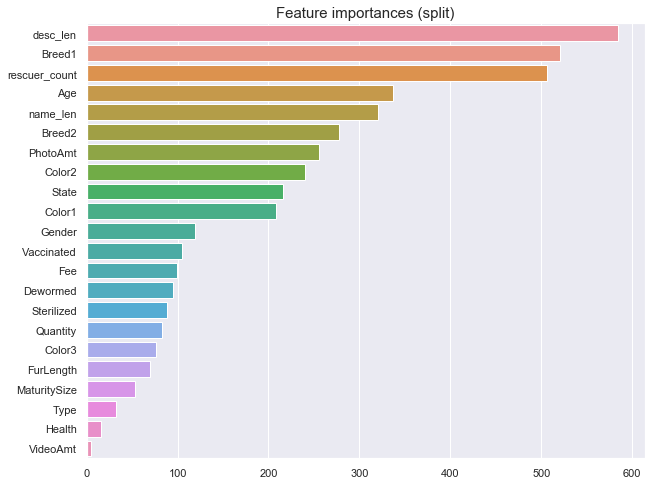

In [79]:
def plot_importances(importances):
    series = pd.Series(data=importances, index=X_train.columns)
    series = series.sort_values(ascending=False)
    plt.figure(figsize=(10, 8))
    sns.barplot(x=series.values, y=series.index)
    plt.title('Feature importances (split)', fontsize=15)
    plt.show()

plot_importances(importances)

## 4. Submission

In [138]:
submission = pd.DataFrame({'PetID': pet_ids_to_submit, 'AdoptionSpeed': preds.astype(np.int32)})
submission.head()
submission.to_csv('submission.csv', index=False)